In [3]:
from google.colab import drive

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


### Load the modules

In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score , f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from imblearn.over_sampling import SMOTE
import xgboost as xgb

from collections import Counter
import pickle
import re
import warnings
warnings.filterwarnings('ignore')

### Load the datasets

In [7]:
train = pd.read_csv('/content/drive/MyDrive/DSN_Bootcamp/TrainDataset.csv')
test = pd.read_csv('/content/drive/MyDrive/DSN_Bootcamp/TestDataset.csv')
var_efinition = pd.read_csv('/content/drive/MyDrive/DSN_Bootcamp/Variable_Definitions.csv')

In [8]:
var_efinition

,Variable defination
0,age
1,sex
2,chest pain type (4 values)
3,resting blood pressure
4,serum cholestoral in mg/dl
5,fasting blood sugar > 120 mg/dl
6,resting electrocardiographic results (values 0...
7,maximum heart rate achieved
8,exercise induced angina
9,oldpeak = ST depression induced by exercise re...


**Uniform Column Names**

In [9]:
train.columns = train.columns.str.lower()

In [10]:
train.columns

Index(['id', 'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
       'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

In [11]:
test.columns = test.columns.str.lower()
test.columns

Index(['id', 'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
       'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')

In [12]:
# check for missing values
train.isna().sum()

,0
id,0
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalach,0
exang,0


In [13]:
# drop the ID column
train.drop('id', axis=1, inplace=True)

In [14]:
target = train['target']
features = train.drop('target', axis=1)

In [15]:
features.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,33,0,1,158,205,1,0,154,0,1.5,1,4,1
1,53,1,2,198,154,0,1,104,0,0.8,2,1,0
2,37,1,2,101,202,1,0,155,0,2.1,1,3,1
3,75,0,0,113,306,1,2,88,1,4.9,0,2,2
4,35,1,2,139,419,1,1,166,1,0.9,2,4,0


In [16]:
# list of non-numerical columns
features.select_dtypes(include=['object']).columns

Index([], dtype='object')

In [17]:
# columns with less than 10 categorical values
less_categories = []
for c in features:
  n = features[c].nunique()
  if n <= 10:
    less_categories.append(c)
  #   print(f"Column [{c}] --> Number of unique values: ({n})")
  #   print(features[c].value_counts())
  # print('\n')



In [18]:
less_categories

['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

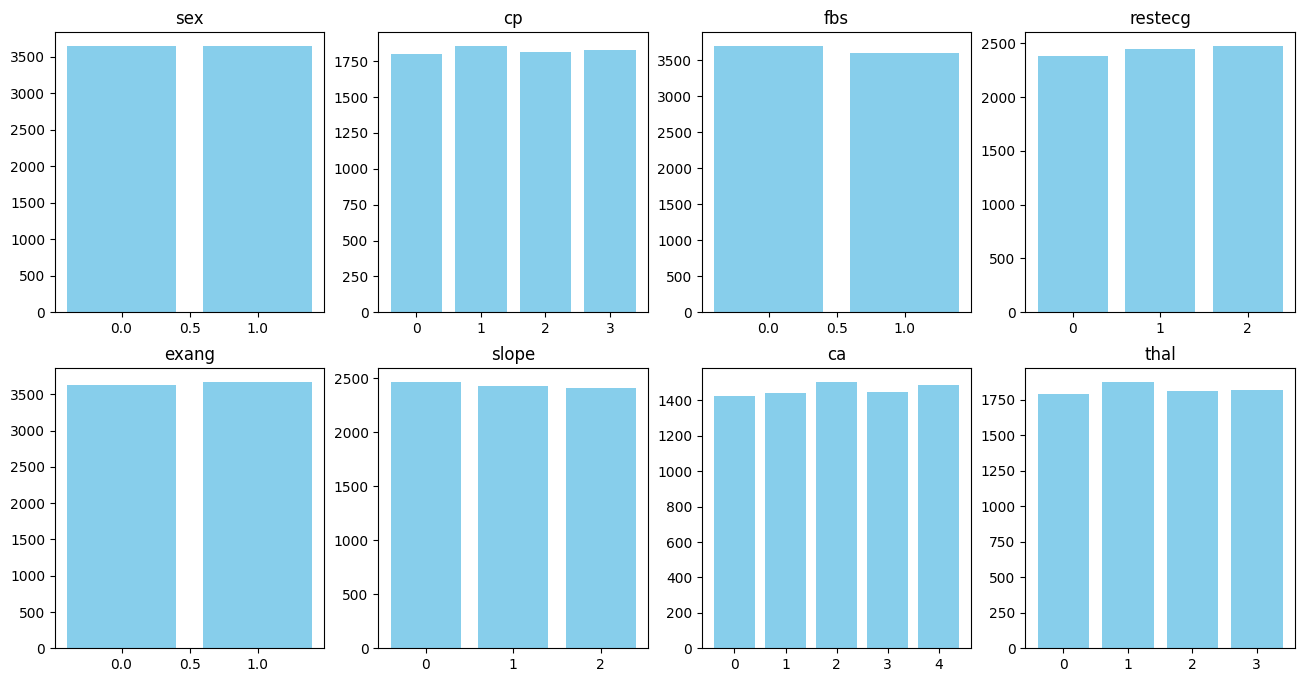

In [19]:
# Create subplots (2 rows, 4 columns)
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Create bar plots for each column
for i, col in enumerate(less_categories):
    bar_table = features[col].value_counts()
    axes[i].bar(bar_table.index, bar_table.values, color='skyblue')
    axes[i].set_title(col)
    # axes[i].set_ylabel(col)

The various categories are evenly distributed so there is no imbalance in the categorical coulmns.

In [20]:
more_categories = features.drop(less_categories, axis=1).columns
more_categories

Index(['age', 'trestbps', 'chol', 'thalach', 'oldpeak'], dtype='object')

In [21]:
features[more_categories].describe()

,age,trestbps,chol,thalach,oldpeak
count,7303.000000,7303.000000,7303.000000,7303.000000,7303.000000
mean,53.172669,147.447487,342.805970,136.506093,3.129851
std,14.185970,31.099538,127.291998,38.141966,1.791160
min,29.000000,94.000000,126.000000,71.000000,0.000000
25%,41.000000,120.000000,231.000000,104.000000,1.600000
50%,53.000000,148.000000,341.000000,137.000000,3.100000
75%,65.000000,174.000000,450.000000,170.000000,4.700000
max,77.000000,200.000000,564.000000,202.000000,6.200000


In [22]:
# number of unique values of the larger categorical columns
for c in more_categories:
  n = features[c].nunique()
  print(f"Column [{c}] --> Number of unique values: ({n})")
  #   print(features[c].value_counts())
  # print('\n')

Column [age] --> Number of unique values: (49)
Column [trestbps] --> Number of unique values: (107)
Column [chol] --> Number of unique values: (439)
Column [thalach] --> Number of unique values: (132)
Column [oldpeak] --> Number of unique values: (63)


In [23]:
# group age columns into:
def age_group(n):
  # if 1 <= n <= 12:
  #   return 0
  # elif 13 <= n <= 19:
  #   return 1
  if 20 <= n <= 35:
    return 1
  elif 36 <= n <= 50:
    return 2
  elif 51 <= n <= 65:
    return 3
  else:
    return 4

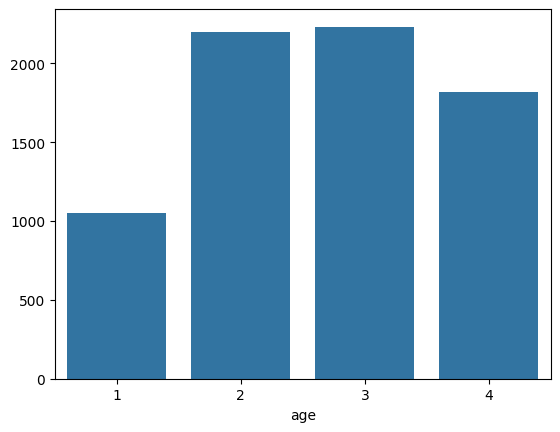

In [24]:
a = features['age'].apply(age_group)
a_series = a.value_counts()

sns.barplot(x=a_series.index, y=a_series.values)
plt.show()

In [25]:
# group oldpeak using range-based binning
def oldpeak_group(col):
  # Assuming oldpeak is in a DataFrame
  result = pd.cut(features['oldpeak'], bins=5, labels=[1, 2, 3, 4, 5]) # ['Very Low', 'Low', 'Moderate', 'High', 'Very High']
  return result

In [26]:
b = oldpeak_group(features['oldpeak'])

<Axes: xlabel='oldpeak'>

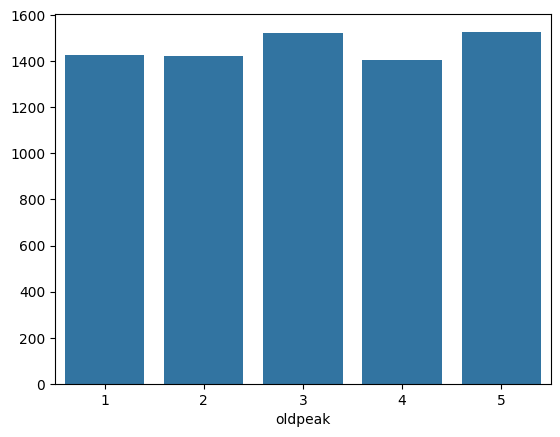

In [27]:
b_series = pd.Series(b).value_counts()

sns.barplot(x=b_series.index, y=b_series.values)

In [28]:
# range of trestbps
def trestbps_group(bp):
    if bp < 120:
        return 1  # Normal
    elif 120 <= bp <= 129:
        return 2  # Elevated
    elif 130 <= bp <= 139:
        return 3  # Hypertension Stage 1
    elif 140 <= bp <= 179:
        return 4  # Hypertension Stage 2
    else:
        return 5  # Hypertensive Crisis

<Axes: xlabel='trestbps'>

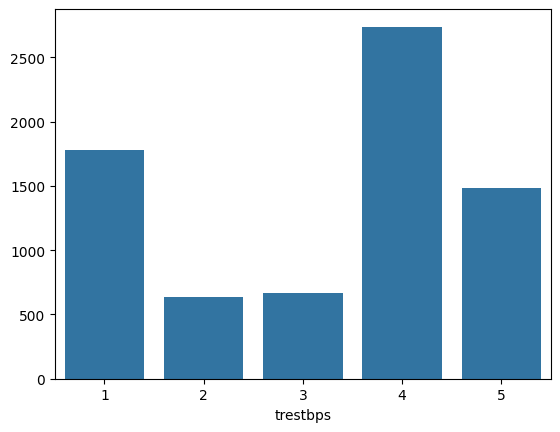

In [29]:
c = features['trestbps'].apply(trestbps_group)
c_series = pd.Series(c).value_counts()

sns.barplot(x=c_series.index, y=c_series.values)

In [30]:
# range of cholesterol
def chol_group(chol):
    if chol < 40:
        return 1  # no chol
    if 40 <= chol < 200:
        return 1  # Good
    elif 200 <= chol <= 239:
        return 2  # Borderline to moderately elevated
    else:
        return 3  # High

<Axes: xlabel='chol'>

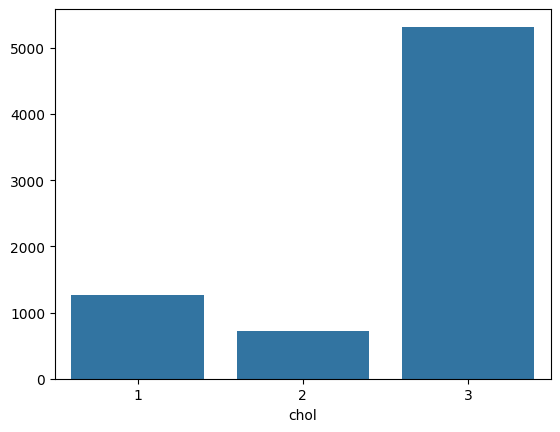

In [31]:
d = features['chol'].apply(chol_group)
d_series = pd.Series(d).value_counts()

sns.barplot(x=d_series.index, y=d_series.values)

In [32]:
# range of thalach: we will leave the heart rate column like that

### Check if the target is balanced

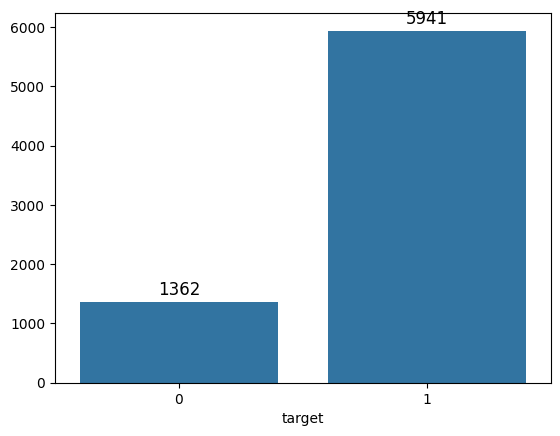

In [33]:
count_target = target.value_counts()
ax = sns.barplot(x=count_target.index, y=count_target.values)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.show()

The target feature is not balanced. We will oversample the feature set:


In [34]:
# smote = SMOTE(random_state=42)
# smote_features, smote_target = smote.fit_resample(features, target)

### Train test split the simple dataset dataset

In [35]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

**One Hot Encode Splitted Set**

In [36]:
# oneot encode the treaining set
ohe_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
train_ohe = ohe_encoder.fit_transform(X_train[less_categories]).toarray()
train_ohe_df = pd.DataFrame(train_ohe, columns=ohe_encoder.get_feature_names_out(less_categories))

In [37]:
# onehot encode the test set
test_ohe = ohe_encoder.transform(X_test[less_categories]).toarray()
test_ohe_df = pd.DataFrame(test_ohe, columns=ohe_encoder.get_feature_names_out(less_categories))

**Scale the numerical column**

In [38]:
# scale the training set
train_scaler = MinMaxScaler()
scaled_train = train_scaler.fit_transform(X_train[more_categories])

scaled_train_df = pd.DataFrame(scaled_train, columns=more_categories)

In [39]:
# scale the test set
scaled_test = train_scaler.transform(X_test[more_categories])

scaled_test_df = pd.DataFrame(scaled_test, columns=more_categories)

**Join the encoded df with the others**

In [75]:
train_concat_df = pd.concat([scaled_train_df, train_ohe_df], axis=1)
test_concat_df = pd.concat([scaled_test_df, test_ohe_df], axis=1)

**Tran the model**

In [76]:
lg = LogisticRegression() # class_weight='balanced'
lg.fit(train_concat_df, y_train)

lg_pred = lg.predict(test_concat_df)

In [77]:
# evaluate the model
print(classification_report(y_test, lg_pred))

              precision    recall  f1-score   support

           0       0.48      0.38      0.42       403
           1       0.87      0.91      0.89      1788

    accuracy                           0.81      2191
   macro avg       0.68      0.64      0.66      2191
weighted avg       0.80      0.81      0.80      2191



In [78]:
# predict the training set
print(classification_report(y_train, lg.predict(train_concat_df)))

              precision    recall  f1-score   support

           0       0.56      0.44      0.49       959
           1       0.88      0.92      0.90      4153

    accuracy                           0.83      5112
   macro avg       0.72      0.68      0.69      5112
weighted avg       0.82      0.83      0.82      5112



**Random Forest**

In [79]:
rf = RandomForestClassifier(random_state=42)
rf.fit(train_concat_df, y_train)

rf_pred = rf.predict(test_concat_df)

# evaluate the model
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.47      0.29      0.36       403
           1       0.85      0.93      0.89      1788

    accuracy                           0.81      2191
   macro avg       0.66      0.61      0.62      2191
weighted avg       0.78      0.81      0.79      2191



In [80]:
# predict the training set
print(classification_report(y_train, rf.predict(train_concat_df)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       959
           1       1.00      1.00      1.00      4153

    accuracy                           1.00      5112
   macro avg       1.00      1.00      1.00      5112
weighted avg       1.00      1.00      1.00      5112



**XGB**

In [81]:
import xgboost as xgb

In [82]:
xgb = xgb.XGBClassifier(random_state=42)
xgb.fit(train_concat_df, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [83]:
xgb_pred = xgb.predict(test_concat_df)

# evaluate the model
print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       0.50      0.47      0.49       403
           1       0.88      0.89      0.89      1788

    accuracy                           0.82      2191
   macro avg       0.69      0.68      0.69      2191
weighted avg       0.81      0.82      0.81      2191



In [84]:
# predict the training set
print(classification_report(y_train, xgb.predict(train_concat_df)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       959
           1       1.00      1.00      1.00      4153

    accuracy                           1.00      5112
   macro avg       1.00      1.00      1.00      5112
weighted avg       1.00      1.00      1.00      5112



**Decision Tree**

In [85]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(train_concat_df, y_train)
dt_pred = dt.predict(test_concat_df)

# evaluate the model
print(classification_report(y_test, dt_pred))

              precision    recall  f1-score   support

           0       0.49      0.49      0.49       403
           1       0.88      0.88      0.88      1788

    accuracy                           0.81      2191
   macro avg       0.69      0.69      0.69      2191
weighted avg       0.81      0.81      0.81      2191



In [86]:
print(classification_report(y_train, dt.predict(train_concat_df)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       959
           1       1.00      1.00      1.00      4153

    accuracy                           1.00      5112
   macro avg       1.00      1.00      1.00      5112
weighted avg       1.00      1.00      1.00      5112



**SVM**

In [87]:
svm = SVC(random_state=42) #, class_weight='balanced'
svm.fit(train_concat_df, y_train)
svm_pred = svm.predict(test_concat_df)

print(classification_report(y_test, svm_pred))

              precision    recall  f1-score   support

           0       0.50      0.40      0.45       403
           1       0.87      0.91      0.89      1788

    accuracy                           0.82      2191
   macro avg       0.68      0.66      0.67      2191
weighted avg       0.80      0.82      0.81      2191



In [88]:
print(classification_report(y_train, svm.predict(train_concat_df)))

              precision    recall  f1-score   support

           0       0.73      0.59      0.65       959
           1       0.91      0.95      0.93      4153

    accuracy                           0.88      5112
   macro avg       0.82      0.77      0.79      5112
weighted avg       0.88      0.88      0.88      5112



### Train on all the dataset and make prediction on the whole test set

In [92]:
test_id = test['id']
test.drop('id', inplace=True, axis=1)

**Smote**

In [55]:
# smote2 = SMOTE(random_state=42)
# smote_features, smote_target = smote2.fit_resample(features, target)

In [56]:
features.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')

In [57]:
test.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')

**OHEncode**

In [93]:
# # oneot encode the treaining set
ohe_encoder2 = OneHotEncoder(drop='first', handle_unknown='ignore')
train_ohe2 = ohe_encoder2.fit_transform(features[less_categories]).toarray()
train_ohe_df2 = pd.DataFrame(train_ohe2, columns=ohe_encoder2.get_feature_names_out(less_categories))

In [94]:
# # onehot encode the test set
test_ohe2 = ohe_encoder2.transform(test[less_categories]).toarray()
test_ohe_df2 = pd.DataFrame(test_ohe2, columns=ohe_encoder.get_feature_names_out(less_categories))

**Scale Numerical Columns**

In [95]:
# scale the training set
train_scaler2 = MinMaxScaler()
scaled_train2 = train_scaler2.fit_transform(features[more_categories])

scaled_train_df2 = pd.DataFrame(scaled_train2, columns=more_categories)

In [96]:
# scale the test set
scaled_test2 = train_scaler2.transform(test[more_categories])

scaled_test_df2 = pd.DataFrame(scaled_test2, columns=more_categories)

**Join all columns**

In [97]:
train_concat_df2 = pd.concat([scaled_train_df2, train_ohe_df2], axis=1)
test_concat_df2 = pd.concat([scaled_test_df2, test_ohe_df2], axis=1)

#### Prediction

**Logistic Regression**

In [98]:
lg2 = LogisticRegression(random_state=42)
lg2.fit(train_concat_df2, target)

test_pred = lg2.predict(test_concat_df2)

**Save the prediciton**

In [99]:
result_lg1 = pd.DataFrame({'ID': test_id, 'Target': test_pred})

In [100]:
result_lg1.Target.value_counts()

,count
Target,
1,2273
0,424


In [101]:
# Step 2: Save the DataFrame as a CSV file
result_lg1.to_csv('lg4.csv', index=False)

**Random Forest**

In [67]:
rf = RandomForestClassifier(random_state=42)
rf.fit(train_concat_df2, target)

test_pred = rf.predict(test_concat_df2)

In [68]:
result_rf = pd.DataFrame({'ID': test_id, 'Target': test_pred})
result_rf.to_csv('rf3.csv', index=False)

**XGB**

In [69]:
import xgboost as xgb

In [70]:
xgb = xgb.XGBClassifier(random_state=42)
xgb.fit(train_concat_df2, target)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [71]:
test_pred = xgb.predict(test_concat_df2)

result_xgb = pd.DataFrame({'ID': test_id, 'Target': test_pred})
result_xgb.to_csv('xgb3.csv', index=False)

**SVM**

In [102]:
svm = SVC(random_state=42) # , class_weight='balanced'
svm.fit(train_concat_df2, target)
svm_pred = svm.predict(test_concat_df2)

In [103]:
result_svm = pd.DataFrame({'ID': test_id, 'Target': svm_pred})
result_svm.to_csv('svm4.csv', index=False)